In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import glob
import sys
import os
import cv2
import numpy as np
print(cv2.__version__)

3.1.0


---

## Load Traffic Lights data



In [3]:
from data_utils import load_tl_extracts

In [4]:
desired_dim = (32,32)

In [5]:
data_dirs = ['data/tl-extract-train', 'data/tl-extract-test', 'data/tl-extract-additional']

In [6]:
# OpenCV uses H, W, C. and C is ordered BGR
x, y = load_tl_extracts(data_dirs, desired_dim)

In [7]:
x.shape

(24504, 32, 32, 3)

In [8]:
y.shape

(24504,)

In [9]:
y_set = set(y)
y_dict = {y: i for i,y in enumerate(y_set)}
y_n = [y_dict[el] for el in y]
n_classes = len(y_set)

---

## Filter only classes relevant for us



{'green': 3,
 'greenleft': 2,
 'greenright': 8,
 'greenstraight': 0,
 'greenstraightleft': 5,
 'greenstraightright': 12,
 'off': 6,
 'red': 9,
 'redleft': 7,
 'redright': 1,
 'redstraight': 10,
 'redstraightleft': 4,
 'yellow': 11}

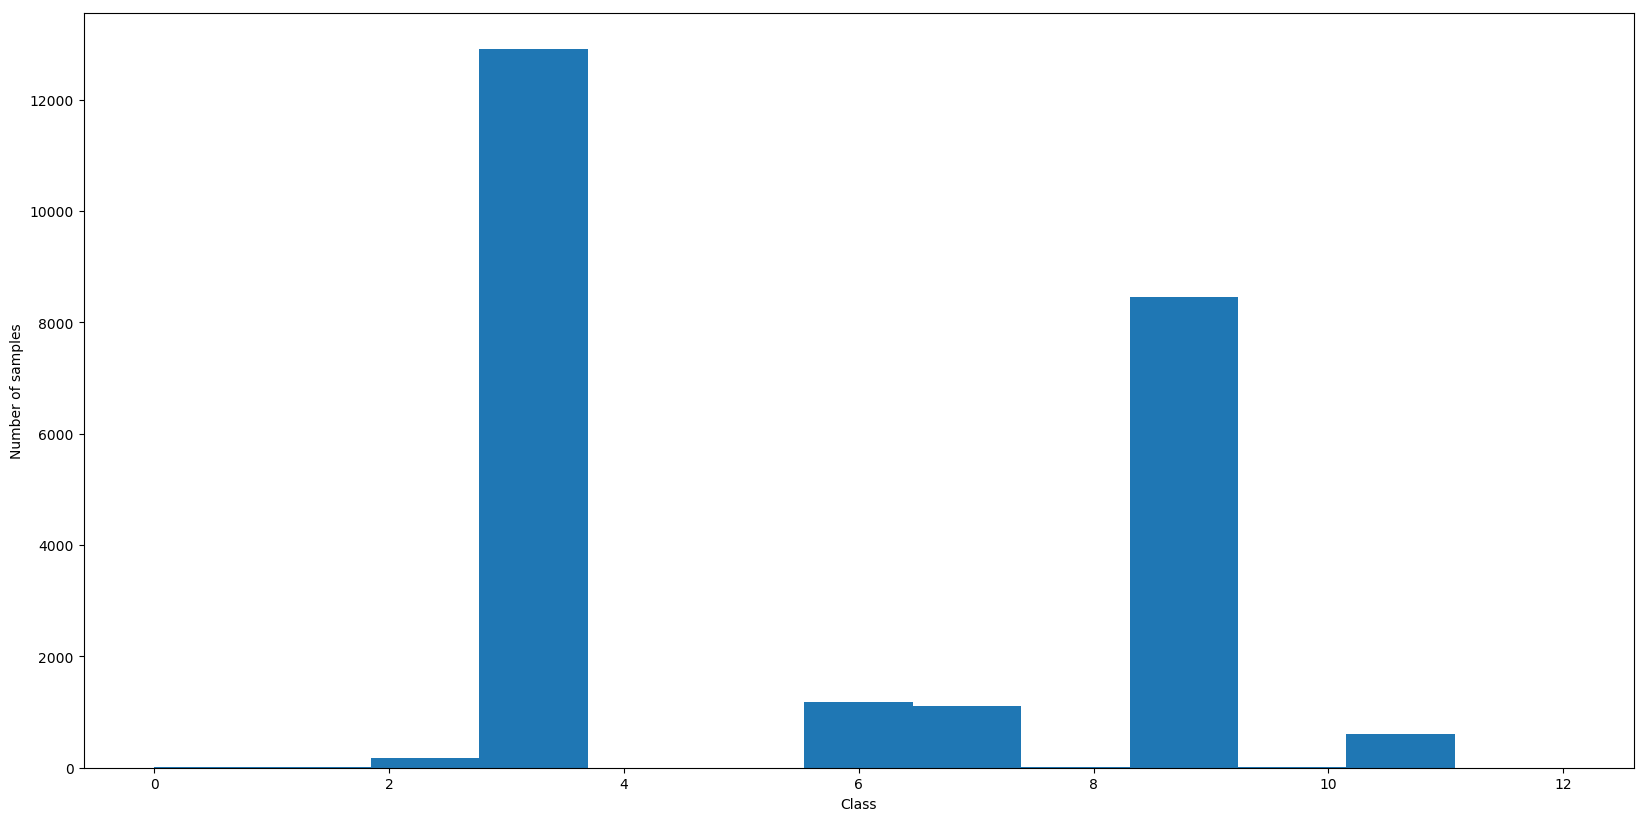

In [10]:
#distribution of examples per class
plt.hist(y_n, bins=n_classes);
plt.xlabel('Class');
plt.ylabel('Number of samples');
y_dict

In [11]:
relevant = ['green','off','yellow','red']
x2 = x[np.isin(y, relevant)]
y2 = y[np.isin(y, relevant)]

In [12]:
x2.shape

(23164, 32, 32, 3)

In [13]:
y2_set = set(y2)
y2_dict = {y: i for i,y in enumerate(y2_set)}
y2_n = [y_dict[el] for el in y2]
n_classes = len(y2_set)

{'green': 2, 'off': 0, 'red': 3, 'yellow': 1}

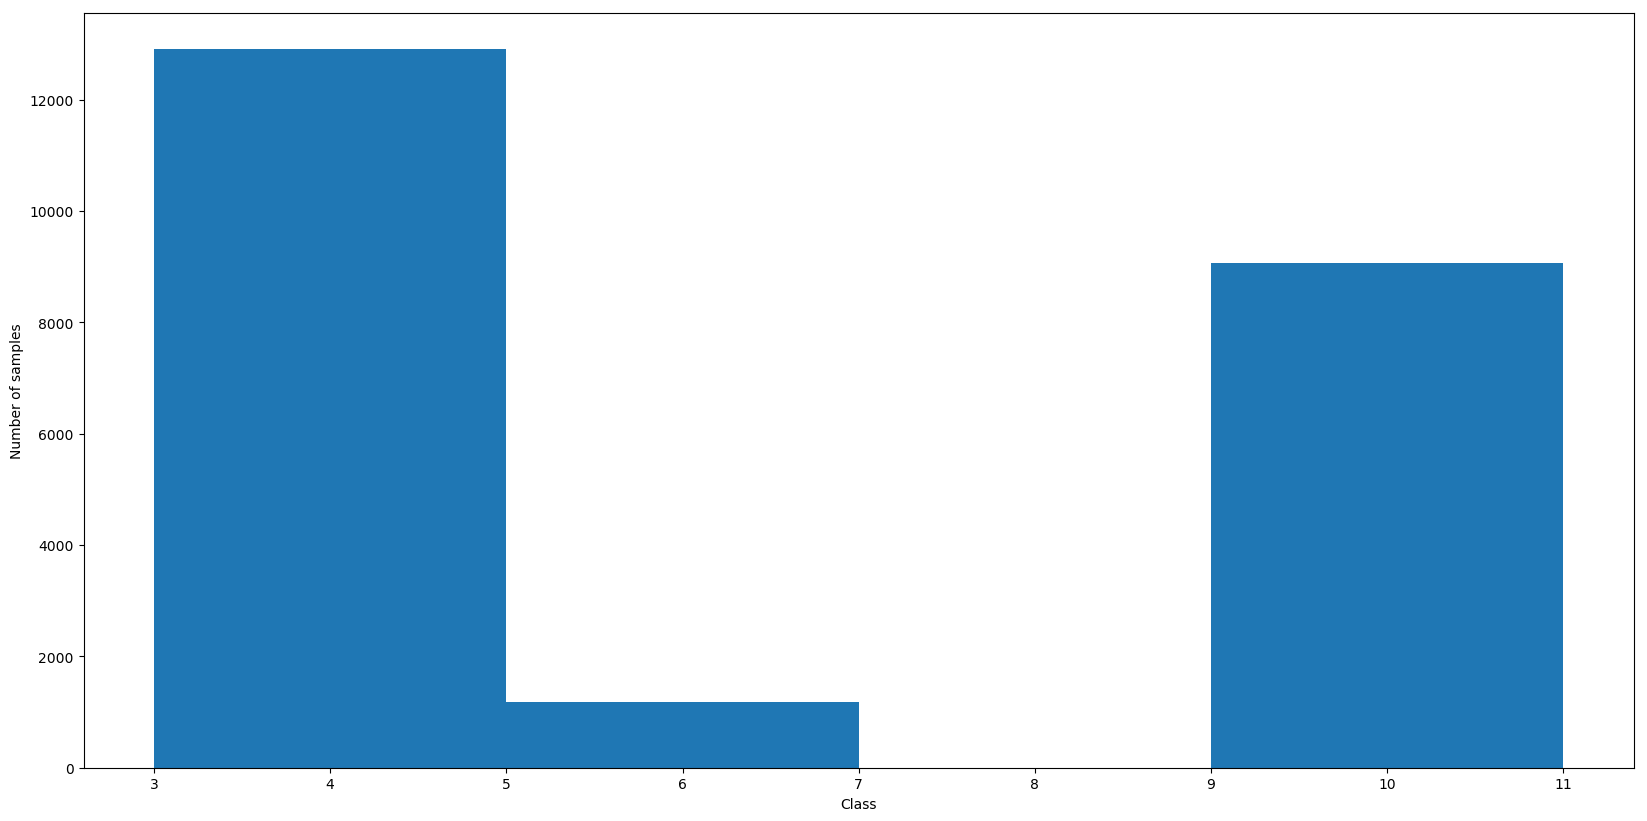

In [14]:
#distribution of examples per class
plt.hist(y2_n, bins=n_classes);
plt.xlabel('Class');
plt.ylabel('Number of samples');
y2_dict

---

## Visualize Data



In [15]:
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

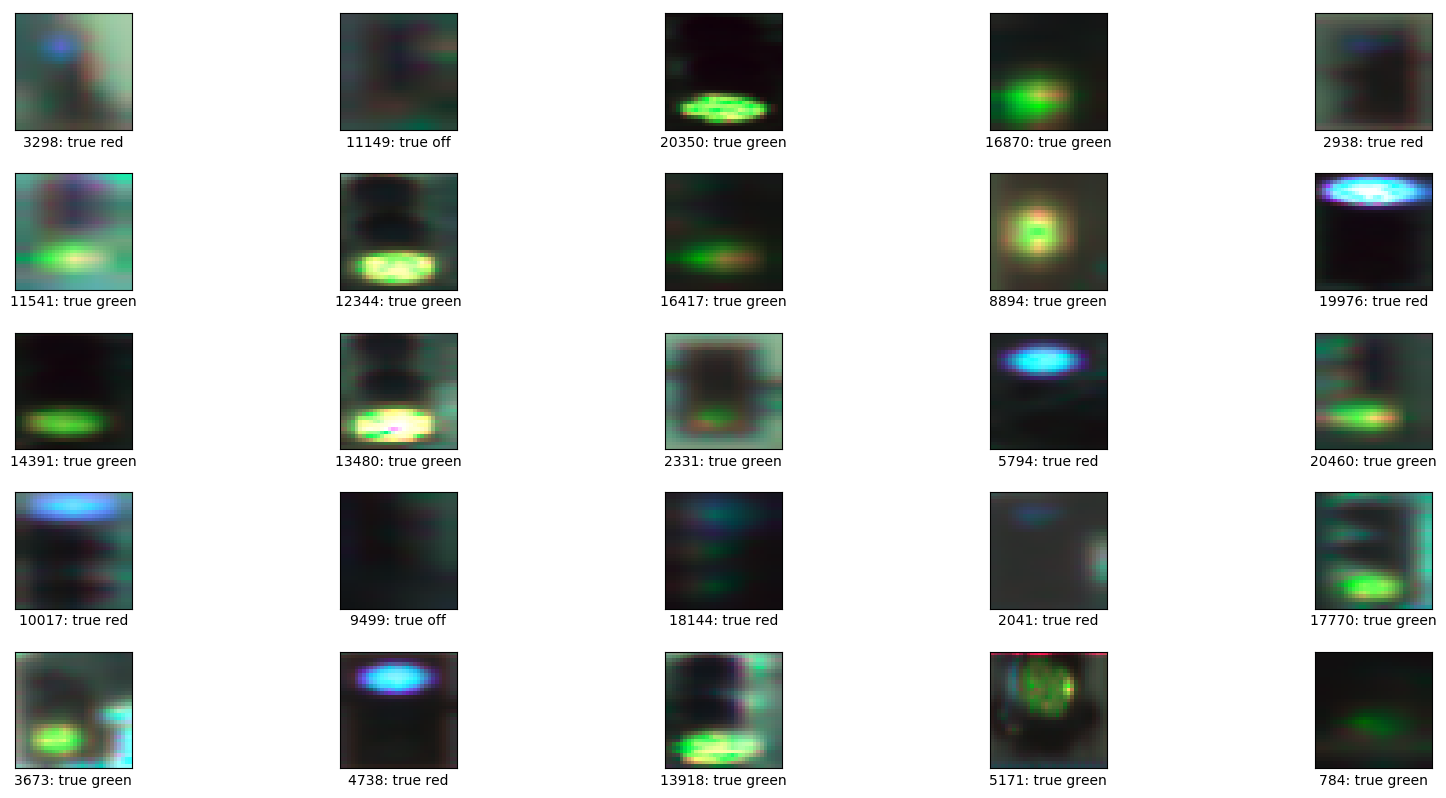

In [16]:
# randomly show grid 5x5 examples from training data set and their true class
rows = 5
cols = 5
cls = None
show_images(x2, y2, rows, cols, cls)

----

## Preprocess and split train/test


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [18]:
x = x2
y = y2

In [19]:
# apply One-Hot Encoding for class labels. at the moment they are integers 0..42
encoder = LabelBinarizer()
encoder.fit(y)
y_onehot = encoder.transform(y)
# Change to float32, so it can be multiplied against the features in 
# TensorFlow, which are float32
y_onehot = y_onehot.astype(np.float32)

In [20]:
pct_train = 85.
pct_valid = 15.
random_state = 123

train_features, val_features, train_labels, val_labels = train_test_split(
                                                            x, y_onehot, 
                                                            train_size = pct_train/100., 
                                                            test_size = pct_valid/100.,
                                                            random_state = random_state)

In [21]:
train_features.shape

(19689, 32, 32, 3)

In [22]:
train_features.dtype

dtype('uint8')

In [23]:
train_labels.shape

(19689, 4)

In [24]:
def normalize_data(image_data):
    return np.true_divide(np.subtract(image_data, np.array([128.])), np.array([256.]))

In [25]:
# normalised images in training and test sets
#x_train_norm = normalize_data(X_train)


----

## Design and Test a Model Architecture


In [26]:
import tensorflow as tf
from tqdm import tqdm
import math
from datetime import datetime

In [27]:
class TrafficLightsClassifier:
    # initialization defaults as class variables
    _trunc_normal_stddev = 0.05
    _bias_init = 0.1
    _L1_kernel_size = 5
    _L1_out_channels = 64
    _kernel1_strides = [1, 1, 1, 1]
    _pool1_kernel = [1, 2, 2, 1]
    _pool1_strides = [1, 2, 2, 1]
    _L2_kernel_size = 5
    _L2_out_channels = 32
    _kernel2_strides = [1, 1, 1, 1]
    _pool2_kernel = [1, 2, 2, 1]
    _pool2_strides = [1, 2, 2, 1]
    
    def __init__(self):
        # input placeholders
        self._images = None
        self._labels = None
        # transform input
        self._images_float = None
        self._images_std = None
        # layer setup
        # Layer 1
        self._kernel1 = None
        self._conv1 = None
        self._bias1 = None
        self._biased1 = None
        self._conv1r = None
        self._pool1 = None
        # Layer 2
        self._kernel2 = None
        self._conv2 = None
        self._bias2 = None
        self._biased2 = None
        self._conv2r = None
        self._pool2 = None
        # reshape
        self._reshape2 = None
        # dropout
        self._keep_prob = None
        self._dropout = None
        # Level 3 FC
        self._weights3 = None
        self._biases3 = None
        self._local3 = None
        # softmax
        self._prediction = None
        self._cross_entropy = None
        self._loss = None
        self._true_class = None
        self._predicted_class = None
        self._accuracy = None
        # savers
        self._model_param_file = None
        self._saver = None
        self._summary_dir = None
        self._summaries = None
        self._summary_writer = None
        # optimizer
        self._optimizer = None
    
    def variable_summaries(self, var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean/'+str(var.name).replace(":","_"), mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev/'+str(var.name).replace(":","_"), stddev)
            tf.summary.scalar('max/'+str(var.name).replace(":","_"), tf.reduce_max(var))
            tf.summary.scalar('min/'+str(var.name).replace(":","_"), tf.reduce_min(var))
            tf.summary.histogram('histogram/'+str(var.name).replace(":","_"), var)
    
    def define_model(self, features_shape, labels_shape):
        """Takes batch of OpenCV images of type uint8. Does normalization internally"""
        self._images = tf.placeholder(tf.uint8, shape=features_shape, name='images')
        self._labels = tf.placeholder(tf.float32, name='labels')

        # convert type and standardise image to [0,1] values
        self._images_float = tf.image.convert_image_dtype(self._images, tf.float32)
        self._images_std = tf.map_fn(lambda img: tf.image.per_image_standardization(img), self._images_float)
        #self._images_std = tf.image.per_image_standardization(self._images_float)
                
        # layer 1
        k1_params = [self._L1_kernel_size, self._L1_kernel_size, features_shape[3], self._L1_out_channels]
        self._kernel1 = tf.Variable(tf.truncated_normal(k1_params, stddev=self._trunc_normal_stddev), name='L1_kernel')
        self.variable_summaries(self._kernel1)
        self._conv1 = tf.nn.conv2d(self._images_std, self._kernel1, strides=self._kernel1_strides, padding='SAME')
        tf.summary.histogram('conv1', self._conv1)
        self._bias1 = tf.Variable(tf.constant(np.ones(self._L1_out_channels, np.float32)*self._bias_init), name='L1_bias')
        self.variable_summaries(self._bias1)
        self._biased1 = tf.nn.bias_add(self._conv1, self._bias1)
        self._conv1r = tf.nn.relu(self._biased1)
        tf.summary.histogram('conv1r', self._conv1r)
        self._pool1 = tf.nn.max_pool(self._conv1r, 
                                       ksize = self._pool1_kernel, 
                                       strides = self._pool1_strides,
                                       padding='SAME')
        tf.summary.histogram('pool1', self._pool1)
        # layer 2
        k2_params = [self._L2_kernel_size, self._L2_kernel_size, self._L1_out_channels, self._L2_out_channels]
        self._kernel2 = tf.Variable(tf.truncated_normal(k2_params, stddev=self._trunc_normal_stddev), name='L2_kernel')
        self.variable_summaries(self._kernel2)
        self._conv2 = tf.nn.conv2d(self._pool1, self._kernel2, strides=self._kernel2_strides, padding='SAME')
        tf.summary.histogram('conv2', self._conv2)
        self._bias2 = tf.Variable(tf.constant(np.ones(self._L2_out_channels, np.float32)*self._bias_init), name='L2_bias')
        self.variable_summaries(self._bias2)
        self._biased2 = tf.nn.bias_add(self._conv2, self._bias2)
        self._conv2r = tf.nn.relu(self._biased2)
        tf.summary.histogram('conv2r', self._conv2r)
        self._pool2 = tf.nn.max_pool(self._conv2r, 
                               ksize = self._pool2_kernel,
                               strides = self._pool2_strides, 
                               padding='SAME')
        tf.summary.histogram('pool2', self._pool2)
        # reshape
        shape = self._pool2.get_shape().as_list()
        dim = np.prod(shape[1:])
        self._reshape2 = tf.reshape(self._pool2, [-1, dim])
        # DROPOUT
        self._keep_prob = tf.placeholder(tf.float32, name='dropout_keep_probability')
        self._dropout = tf.nn.dropout(self._reshape2, self._keep_prob)
        tf.summary.histogram('dropout', self._dropout)
        tf.summary.scalar('dropout_keep_probability', self._keep_prob)
        # layer 3 fully connected
        init_range = math.sqrt(6.0 / (dim + labels_shape[1]))
        self._weights3 = tf.Variable(tf.random_uniform([dim, labels_shape[1]], -init_range, init_range), name='FC1_weights')
        self.variable_summaries(self._weights3)
        self._biases3 = tf.Variable(tf.constant(np.ones(labels_shape[1], np.float32)*self._bias_init), name='FC1_bias')
        self.variable_summaries(self._biases3)
        self._local3 = tf.matmul(self._dropout, self._weights3) + self._biases3
        tf.summary.histogram('local3', self._local3)
        # softmax
        self._prediction = tf.nn.softmax(self._local3)
        tf.summary.histogram('prediction', self._prediction)
        # Cross entropy
        self._cross_entropy = tf.reduce_mean(-tf.reduce_sum(
                                            self._labels * tf.log(tf.clip_by_value(self._prediction,1e-10,1.0)), 
                                            reduction_indices=[1]))
        tf.summary.scalar('xentropy', self._cross_entropy)
        # training loss
        self._loss = tf.reduce_mean(self._cross_entropy)
        tf.summary.scalar('loss', self._loss)
        # accuracy
        self._true_class      = tf.argmax(self._labels, 1)
        self._predicted_class = tf.argmax(self._prediction, 1)
        self._accuracy = tf.reduce_mean(tf.cast(tf.equal(self._predicted_class, self._true_class), tf.float32))
        tf.summary.histogram('accuracy', self._accuracy)

    def set_save_files(self, model_param_file, summary_dir=None):
        self._model_param_file = model_param_file
        self._saver = tf.train.Saver()
        if summary_dir is not None:
            self._summary_dir = summary_dir
            self._summaries = tf.summary.merge_all()
            
    def create_session(self, learning_rate=0.001):
        # optimizer needs to be here to initialize its variables
        # leaving learning rate
        self._optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self._loss)
        
        # init
        init = tf.global_variables_initializer()
        #init = tf.initialize_all_variables()
        #GPU config
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.9
        #session
        self._session = tf.Session(config=config)
        self._session.run(init)
        #summary writer
        if self._summary_dir is not None:
            self._summary_writer = tf.summary.FileWriter(self._summary_dir, self._session.graph)

    def restore_variables(self):
        if self._session is not None:
            self._saver.restore(self._session, self._model_param_file)
        
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
            
    def train(self, 
              train_images, 
              train_labels, 
              validation_images=None, 
              validation_labels=None, 
              learning_rate=0.001, 
              dropout_keep_probability=0.5,
              batch_size=150, 
              epochs=50, 
              max_iterations_without_improvement=5):
        
        # Measurements use for graphing loss and accuracy
        best_validation_accuracy = 0.0
        last_improvment_epoch = 0
        loss_epoch = []
        train_acc_epoch = []
        valid_acc_epoch = []

        st = datetime.now()

        a_ = 0

        for epoch_i in range(epochs):
            # train for one epoch

            # random training set permutation for each epoch
            perm_index = np.random.permutation(len(train_images))
            train_images = train_images[perm_index,:,:,:]
            train_labels = train_labels[perm_index]

            # running optimization in batches of training set
            batch_count = int(math.ceil(len(train_images)/batch_size))
            batches_pbar = tqdm(range(batch_count), desc='Train Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
            for batch_i in batches_pbar:
                batch_start = batch_i*batch_size
                batch_images = train_images[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]
                # Run optimizer and get loss
                _, l, _summ = self._session.run(
                    [self._optimizer, self._loss, self._summaries],
                    feed_dict={self._images: batch_images, 
                               self._labels: batch_labels, 
                               self._keep_prob: dropout_keep_probability})
            # write summaries once per epoch
            _summ = self._session.run(
                [self._summaries],
                feed_dict={self._images: batch_images, 
                           self._labels: batch_labels, 
                           self._keep_prob: dropout_keep_probability})
            self._summary_writer.add_summary(_summ[0], epoch_i)

            # Log accuracy every epoch. have to calculate accuracy in batches as cannot 
            # fit entire test set on GPU
            # training accuracy
            batch_count = int(math.ceil(len(train_images)/batch_size))
            batches_pbar = tqdm(range(batch_count), desc='Train Accuracy Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
            l = 0.
            a = 0.
            for batch_i in batches_pbar:
                batch_start = batch_i*batch_size
                batch_images = train_images[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]
                l_, a_ = self._session.run(
                    [self._loss, self._accuracy],
                    feed_dict={self._images: batch_images, 
                               self._labels: batch_labels, 
                               self._keep_prob: 1.0})
                l += l_ * len(batch_images)
                a += a_ * len(batch_images)
            loss_epoch.append(l / len(train_images))
            train_acc_epoch.append(a / len(train_images))
            
            if validation_images is None:
                validation_images = train_images
                validation_labels = train_labels
            
            # validation accuracy
            batch_count = int(math.ceil(len(validation_images)/batch_size))
            batches_pbar = tqdm(range(batch_count), desc='Val Accuracy Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
            a = 0.
            for batch_i in batches_pbar:
                batch_start = batch_i*batch_size
                batch_images = validation_images[batch_start:batch_start + batch_size]
                batch_labels = validation_labels[batch_start:batch_start + batch_size]
                # Run optimizer and get loss
                a_ = self._session.run(
                    [self._accuracy],
                    feed_dict={self._images: batch_images, 
                               self._labels: batch_labels, 
                               self._keep_prob: 1.0})
                a += a_[0] * len(batch_images)
            validation_accuracy = a / len(validation_images)
            valid_acc_epoch.append(validation_accuracy)
            print('epoch {}, val accuracy: {}'.format(epoch_i, validation_accuracy))
            if (validation_accuracy > best_validation_accuracy):
                best_validation_accuracy = validation_accuracy
                last_improvment_epoch = epoch_i
                # save checkpoint every time accuracy improved during the epoch
                self._saver.save(self._session, self._model_param_file)
                print('***') # signify accuracy improvement iteration
            else:
                if (epoch_i - last_improvment_epoch >= max_iterations_without_improvement):
                    break # stop learning
        print('runtime: {}'.format(datetime.now()-st))
        print('best val accuracy: {}'.format(best_validation_accuracy))
        print('epochs: {}'.format(epoch_i))
        return loss_epoch, train_acc_epoch, valid_acc_epoch, best_validation_accuracy

    def predict(self, 
              images, 
              true_labels=None, 
              batch_size=150):

        # Measurements use for graphing loss and accuracy
        predicted_probabilities = []
        predicted_classes = []
        accuracy = 0
        batch_count = int(math.ceil(len(images)/batch_size))
        for batch_i in range(batch_count):
            batch_start = batch_i*batch_size
            ops = [self._prediction, self._predicted_class]
            feed_dict={self._images: images[batch_start:batch_start + batch_size], 
                       self._keep_prob: 1.0}
            if true_labels is not None:
                ops.append(self._accuracy)
                feed_dict[self._labels] = true_labels[batch_start:batch_start + batch_size]
            # Run optimizer and get loss
            output = self._session.run(ops, feed_dict=feed_dict)
            predicted_probabilities.append(output[0])
            predicted_classes.append(output[1])
            accuracy += output[2] * len(feed_dict[self._images])
        accuracy /= len(images)
        return np.vstack(predicted_probabilities), np.hstack(predicted_classes), accuracy
        

Below is Tensorboard visualisation of the main part of my network (before softmax).

Here is the description of it:

1. input features. shape: (?, 32, 32, 3)
2. convolution. kernel: [5,5] 3 input channels, 64 output channels. strides [1,1,1,1]. SAME padding.
3. add bias
4. relu
5. max pool. strides [1,2,2,1]. kernel [1,2,2,1]. SAME padding
6. convolution. kernel: [5,5] 64 input channels, 32 output channels. strides [1,1,1,1]. SAME padding.
7. add bias
8. relu
9. max pool. strides [1,2,2,1]. kernel [1,2,2,1]. SAME padding
10. reshape to flatten features. 2048 features
11. dropout with keep_probability=0.5
12. fully connected W*x+bias. output: number of classes
13. softmax to get label probabilities

.

In [28]:
from IPython.display import Image
Image('CNN-graph.png')

In [29]:
# define shapes
features_shape = ((None,) + train_features.shape[1:])
labels_shape = (None,train_labels.shape[1],)

# create classifier
tsc = TrafficLightsClassifier()

# define model
tsc.define_model(features_shape=features_shape, labels_shape=labels_shape)

In [30]:
# where we save trained variables
model_param_file = 'ckpt/model.ckpt'

# where we save graph and events/summaries for tensorflow
summary_dir = 'train_summaries'

tsc.set_save_files(model_param_file, summary_dir)

In [32]:
# learning parameters
epochs = 10
batch_size = 250
learning_rate = 0.001
max_iterations_without_improvement = 10
dropout_keep_probability=0.5

In [33]:
# create Tensorflow session
tsc.create_session(learning_rate)

In [34]:
# i have trained model several times, restarting from where I left off, sometimes changing parameters
#tsc.restore_variables()

In [ ]:
# main training
loss_epoch, train_acc_epoch, valid_acc_epoch, best_validation_accuracy = \
    tsc.train(train_images      = train_features, 
              train_labels      = train_labels, 
              validation_images = val_features, 
              validation_labels = val_labels, 
              learning_rate     = learning_rate, 
              dropout_keep_probability = dropout_keep_probability,
              batch_size        = batch_size, 
              epochs            = epochs, 
              max_iterations_without_improvement = max_iterations_without_improvement)

Val Accuracy Epoch  1/10: 100%|██████████| 14/14 [00:02<00:00,  3.42batches/s]


epoch 0, val accuracy: 0.9660432124309403


Train Epoch  2/10:   0%|          | 0/79 [00:00<?, ?batches/s]

***


Val Accuracy Epoch  2/10: 100%|██████████| 14/14 [00:02<00:00,  5.30batches/s]


epoch 1, val accuracy: 0.9703597889529715


Train Epoch  3/10:   0%|          | 0/79 [00:00<?, ?batches/s]

***


Val Accuracy Epoch  3/10: 100%|██████████| 14/14 [00:03<00:00,  4.49batches/s]


epoch 2, val accuracy: 0.9720863965775469


Train Epoch  4/10:   0%|          | 0/79 [00:00<?, ?batches/s]

***


Train Epoch  5/10:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 3, val accuracy: 0.9709353356910266


Train Epoch  6/10:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 4, val accuracy: 0.9692087061971212


Train Epoch  7/10:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 5, val accuracy: 0.9715108682783388


Val Accuracy Epoch  7/10: 100%|██████████| 14/14 [00:04<00:00,  4.08batches/s]


epoch 6, val accuracy: 0.9743885693790244


Train Epoch  8/10:   0%|          | 0/79 [00:00<?, ?batches/s]

***


Train Accuracy Epoch  8/10:  44%|████▍     | 35/79 [00:07<00:10,  4.07batches/s]

In [ ]:
STOP

In [ ]:
# accuracy statistics for last epoch (train set and validation set). and also best seen validation set accuracy 
train_acc_epoch[-1], best_validation_accuracy

In [ ]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(loss_epoch, 'g')
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(valid_acc_epoch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.legend(loc=2)
plt.tight_layout()
plt.show()

## investigating accuracy on out of sample data

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images=val_features, 
              true_labels=val_labels, 
              batch_size=150)


In [ ]:
accuracy

In [ ]:
# great, accuracy 99.74% on validation set.

In [ ]:
predicted_probabilities.shape

In [ ]:
predicted_probabilities[0]

In [ ]:
predicted_classes[0]

In [ ]:
certainty = predicted_probabilities.max(axis=1)

In [ ]:
plt.hist(certainty, bins=100);

In [ ]:
len(certainty[certainty<.98])

In [ ]:
plt.plot(certainty[certainty<.98]);

In [ ]:
# hm, interesting. the model is very opinionated and classifies vast majority of images with 98%+ certainty

In [ ]:
# NOW test model predictions on test.p data which was not used in training or cross-validation

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images = x_test_norm, 
              true_labels = y_test_norm, 
              batch_size = 150)


In [ ]:
accuracy

In [ ]:
# 95.64% accuracy. great! model generalises very well! lets analyse what is working and what is not.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def print_test_accuracy(images, cls_pred, cls_true, 
                        show_example_errors=False,
                        show_confusion_matrix=False):
    num_test = len(images)
    num_classes = len(set(cls_true))

    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        incorrect = (correct == False)
        im = images[incorrect]
        cp = cls_pred[incorrect]
        ct = cls_true[incorrect]
        show_images(im, ct, 3, 4, labels_predicted=cp, random=False)
                
    if show_confusion_matrix:
        print("Confusion Matrix (log):")
        # Get the confusion matrix using sklearn.
        cm = confusion_matrix(y_true=cls_true,
                              y_pred=cls_pred)
        #print(cm)
        plt.matshow(np.log(cm))
        plt.colorbar()
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, range(num_classes))
        plt.yticks(tick_marks, range(num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()        

In [ ]:
# lets look at first 26x26 cells of confusion matrix
cm = confusion_matrix(y_true=y_test,
                      y_pred=predicted_classes)
np.set_printoptions(threshold=np.nan, linewidth=200)
print(cm[:25,:25])
np.set_printoptions(threshold=30, linewidth=75)

In [ ]:
# visualize example error images and confusion matrix
print_test_accuracy(images=X_test, 
                    cls_pred=predicted_classes, 
                    cls_true=y_test, 
                    show_example_errors=True, 
                    show_confusion_matrix=True)

In [ ]:
# read the sign names into a dict
import csv
reader = csv.DictReader(open('signnames.csv'))
signnames = {}
for row in reader:
    signnames[int(row['ClassId'])] = row['SignName']    

In [ ]:
# visualize instances where model is misclassifying big number of images

In [ ]:
def print_one_confusion(images, true_labels, predicted_labels, show_true_class, show_false_class):
    idx = np.logical_and(true_labels==show_true_class, predicted_labels==show_false_class)
    cnt = sum(idx)
    print('true class "{}", predicted class "{}". found: {}'.format(signnames[show_true_class], signnames[show_false_class], cnt))
    cols = int(np.ceil(cnt/10))
    show_images(images[idx], true_labels[idx], cols, 10, random=False, labels_predicted=predicted_labels[idx])

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=21, show_false_class=12)
# what we see here is the same test set image (may be with small transformations) that was misclassified.
# this seems like a genuine defficiency of the model -- the predicted sign is very different visually than the image

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=30, show_false_class=23)
# with this one it looks like the same image, with slight transformations. the quality is quite poor, so its 
# understandable that model had hard time predicting it. the shape of the sign is actually right. and the picture
# inside triangle is not very legible even for a human, so this is probably ok

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=7, show_false_class=5)
# we see in confusion matrix that all the speed limit signs have high misclassification errors between them.
# looks like the quality of the picture need to increase (better resolution is required)
# for model to be more discerning between different speed limits.

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=6, show_false_class=42)
# looks like in this case the model is confused by the 'end' part -- the line across the sign. so it used the shape
# and the cross line as main features. it also interpreted 80 as two vehicles passing each other (see below for
# images of the 'end of passing' sign examples)

In [ ]:
rows = 3
cols = 10
cls = 42
show_images(X_test, y_test, rows, cols, cls)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [ ]:
import scipy as sp
import glob

In [ ]:
imageFolderPath = 'mine/'
imagePath = glob.glob(imageFolderPath+'/*.png') 

In [ ]:
im_array = np.stack( [sp.misc.imresize(sp.misc.imread(file, mode='RGB'), size=(32,32),interp='bicubic') for file in imagePath], axis=0 )

In [ ]:
im_array.shape

In [ ]:
# actually the first one is 'road narrows on the left' -- for UK. but the closest class is 'road narrows on the right'
im_true_label = [24,17,13,0,-1,-1]

In [ ]:
show_images(im_array, im_true_label, rows=2, cols=3, random=False)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

Alexey:

I have taken 6 images around central London. I have then manually selected the signs from the images and saved into files signN.png.
The code above loads them up and re-samples to be 32x32 pixels with full RGB channels.

We see that some signs are at an angle to the camera, some signs are illuminated which makes it hard for camera to get the right picture.

Some of the signs do not appear in the original German data set, i.e. 'no left turn' and 'no right turn'. 'yield' sign has 'give way' words in it, which is absent in training set.

.

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [ ]:
x = normalize_data(im_array)
y = encoder.transform(im_true_label)

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images = x, 
              true_labels = y, 
              batch_size = 150)


In [ ]:
accuracy

In [ ]:
predicted_classes

In [ ]:
im_true_label

In [ ]:
# so we classified two signs correctly: 'no entry' and 'yield'.
# 'road narrows on the right' was classified as 'right of way at next intersection'. this seems sensible -- 
# see below pictures. 'right of way' is also triangular sign with black picture inside. so they can be mistaken.
# 'speed limit 20' became 'speed limit 30'. it could be because its at a slight angle. or it could be differences in
# font between Germany and UK.
# 'no right turn' and 'no left turn' were classified as 'speed limit 50' and 'speed limit 70'. this is interesting.
# given that there is no example of these signs in the data set its easy to see that their features (round red circle
# with black images in the middle) could be attributed to 'speed limit' signs. for 'no left turn' its even
# easy to see that the black line is resembling number 7, so it makes sense how it was classified.

In [ ]:
rows = 3
cols = 10
cls = 11
show_images(X_test, y_test, rows, cols, cls)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Alexey:

Probabilities are presented below for 6 classified signs.
We see that the model is very opinionated with all signs classified with more than 90% 'softmax probability'

.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [ ]:
ax = plt.subplot(111)
x = np.array(range(43), dtype=np.float)
colors = 'rgbycm'
width = 0.2
for i in range(6):
    ax.bar(x+width*i, predicted_probabilities[i],width=0.2,color=colors[i],align='center');

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

Alexey:

With this particular model there is at most one other 'distant second' alternative prediction as is evident from visualisations above. The model is very opinionated and its not worth analysing 'top 5' contendants as model certainty drops to pretty much zero with alternatives 3+.

.


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

Alexey:

I first implemented model as sequence of commands in various cells in the notebook.

After tweaking it and making it work I have re-factored the model into a class that:
1. defines model
2. trains model
3. saves variables
4. restores variables from previous training
5. runs predictions on input images.

The resulting solution is much easier to use and understand. It can be improved, but I have spent more time than allocated already so have to move on to the next project


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [ ]:
tsc.close_session()